# Scan analysis

In [123]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture
from poly2.simulator import SimulatorOneTrait

# Dist scan

In [125]:
df = pd.read_csv('../outputs/combined/fung_scan.csv')

In [126]:
df.head()

run  year  best_dose  n_pos_diff         mu         b
0    0     1        1.0           9  17.879734  2.744068
1    0     2        1.0           9  17.879734  2.744068
2    0     3        1.0           9  17.879734  2.744068
3    0     4        1.0           9  17.879734  2.744068
4    0     5        1.0           9  17.879734  2.744068

In [127]:
noise = np.random.normal(0, 0.05, size=len(df.n_pos_diff))

processed = (
    df
    .assign(
        is_mono = lambda x: (x.n_pos_diff==9).astype(int) + 2*noise,
        n_pos_diff = lambda x: x.n_pos_diff + noise,
        best_dose = lambda x: x.best_dose + 0.1*noise,
    )
)

Text(0, 0.5, 'is monotonic?')

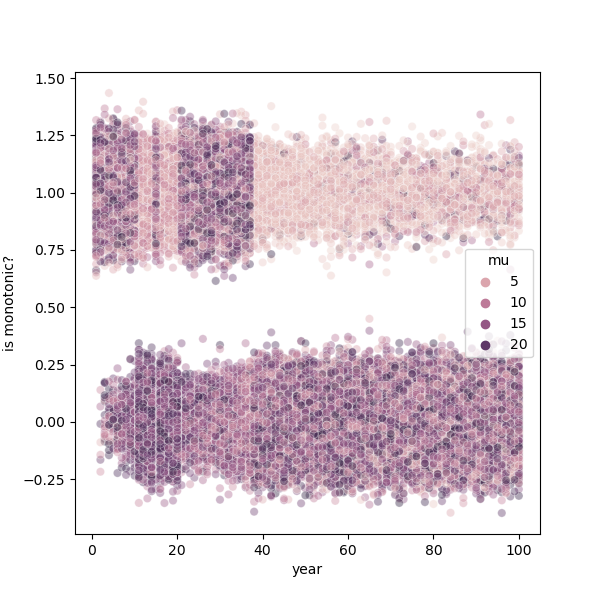

In [128]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='is_mono',
    
    # hue='b',
    hue='mu',
    
    # size='b',
    # size='mu',
    
    data=(
        processed
        # .loc[lambda x: x.mu<12]
        # .loc[lambda x: x.mu>5]
        # .loc[lambda x: x.mu>12]
        
        # .loc[lambda x: x.b>0.5]
        # .loc[lambda x: x.b<1.5]
        
        # .loc[lambda x: x.b>1]
        # .loc[lambda x: x.b>0.2]
    ),
    ax=ax,
    alpha=0.4,
)

ax.set_ylabel('is monotonic?')

Something strange happens when filtering for `mu>12`? Wonder what causes this?

Text(0, 0.5, 'N positive diffs (yield dose i+1 > dose i)')

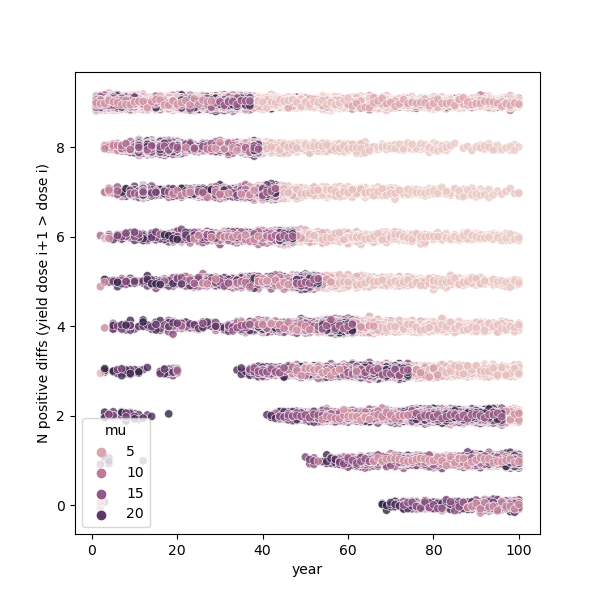

In [129]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='n_pos_diff',
    
    # size='b',
    
    hue='mu',
    # hue='b',
    
    data=(
        processed   
        # .loc[lambda x: x.mu>12]
        # .loc[lambda x: x.mu<12]
        # .loc[lambda x: x.mu>5]
        
        # .loc[lambda x: x.b<1.2]
        # .loc[lambda x: x.b>0.5]
    ),
    ax=ax,
    alpha=0.8,
)

ax.set_ylabel('N positive diffs (yield dose i+1 > dose i)')

(0.0, 50.0)

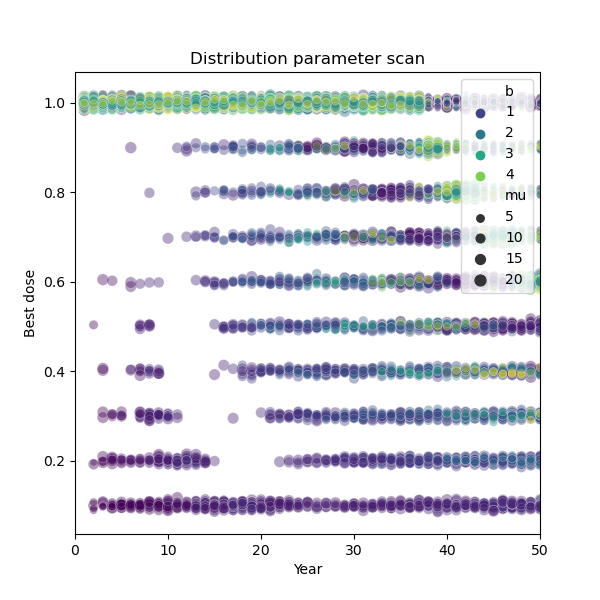

In [130]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='best_dose',
    
    hue='b',
    # hue='mu',
    
    # size='b',
    size='mu',
    
    palette='viridis',
    data=(
        processed
        # .loc[lambda x: x.mu<12]
        # .loc[lambda x: x.mu>5]
        # .loc[lambda x: x.mu>10]
        
        # .loc[lambda x: x.b>0.5]
        # .loc[lambda x: x.b<1.5]
        # .loc[lambda x: x.b>1]
        
        # .loc[lambda x: x.b>1]
        # .loc[lambda x: x.b>0.2]
    ),
    ax=ax,
    alpha=0.4,
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Distribution parameter scan')

ax.legend(loc='upper right')

ax.set_xlim([0,50])

In [133]:
f.savefig('../figures/rough/scan/dist_pars.jpg')

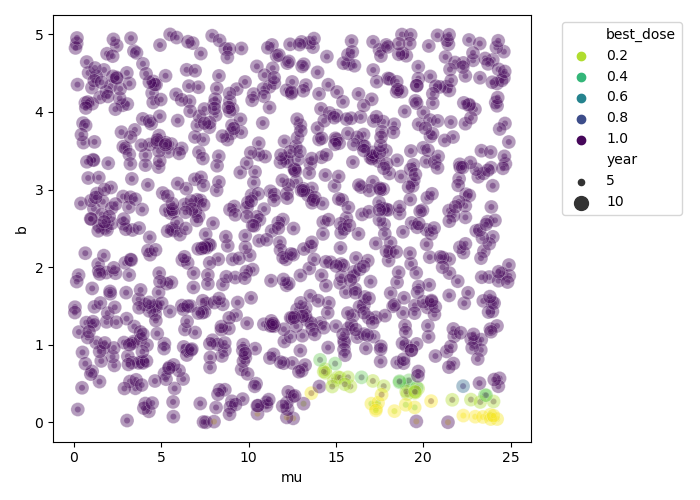

In [174]:
f, ax = plt.subplots(figsize=(7, 5))

dfu = processed.loc[lambda x: x.year.isin([5, 10])]

sns.scatterplot(
    x='mu',
    y='b',
    hue='best_dose',
    # style='year',
    size='year',
    data=dfu,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 100)
    # s=80,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

In [175]:
f.savefig('../figures/rough/scan/dist_pars_colour.jpg')

Text(0.5, 1.0, 'Gamma distribution, mu=17, b=0.1')

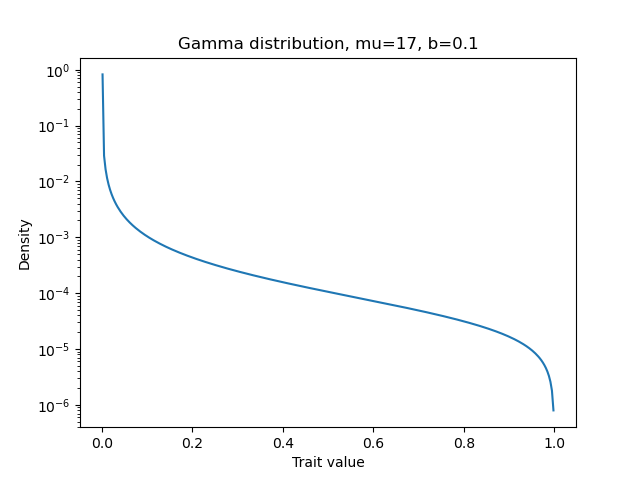

In [141]:
xx = trait_vec(300)

mu = 17
b = 0.1

a = mu*b

yy = gamma_dist(300, a, b)

f, ax = plt.subplots()

ax.plot(xx,yy)

ax.set_xlabel('Trait value')
ax.set_ylabel('Density')

ax.set_yscale('log')

ax.set_title(f'Gamma distribution, {mu=}, {b=}')

In [142]:
f.savefig('../figures/rough/scan/gamma.jpg')

So it looks like they all start off as monotonic increasing in dose. 

Larger values of `b` take longer to become non-monotonic.

Seemingly all are heading that way so that after an intermediate amount of time low doses best.

Seemingly the ones that happen quickly are big `mu>10` and small `b<1.5`

# Fung pars scan

In [143]:
dp = pd.read_csv('../outputs/combined/fung_pars_scan.csv')

In [144]:
dp.head()

run  year  best_dose  n_pos_diff  asymptote  dec_rate_multiplier
0    0     1        1.0           9   0.548814             2.240505
1    0     2        1.0           9   0.548814             2.240505
2    0     3        1.0           9   0.548814             2.240505
3    0     4        1.0           9   0.548814             2.240505
4    0     5        1.0           9   0.548814             2.240505

In [145]:
noise_p = np.random.normal(0, 0.05, size=len(dp.n_pos_diff))

processed_p = (
    dp
    .assign(
        is_mono = lambda x: (x.n_pos_diff==9).astype(int) + 2*noise,
        n_pos_diff = lambda x: x.n_pos_diff + noise,
        best_dose = lambda x: x.best_dose + 0.15*noise,
    )
)

Text(0, 0.5, 'is monotonic?')

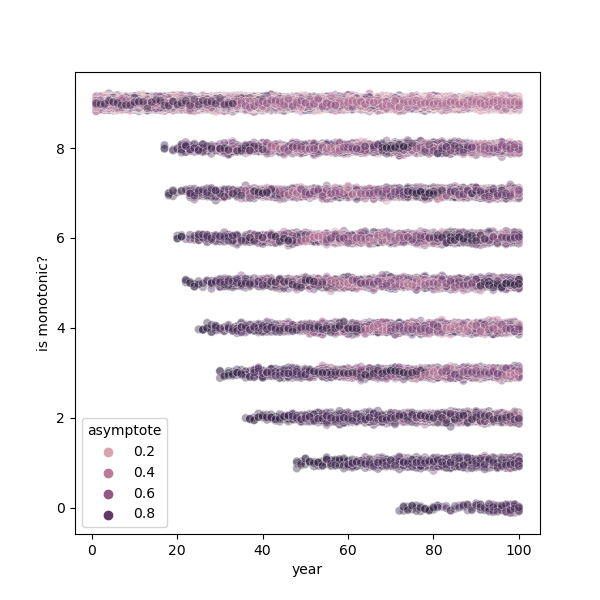

In [146]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='n_pos_diff',
    
    # hue='dec_rate_multiplier',
    hue='asymptote',
    
    # size='b',
    # size='mu',
    
    data=(
        processed_p
        # .loc[lambda x: x.mu<12]
        # .loc[lambda x: x.mu>5]
        
        # .loc[lambda x: x.b>3]
        # .loc[lambda x: x.b>0.2]
    ),
    ax=ax,
    alpha=0.4,
)

ax.set_ylabel('is monotonic?')

Text(0, 0.5, 'N positive diffs (yield dose i+1 > dose i)')

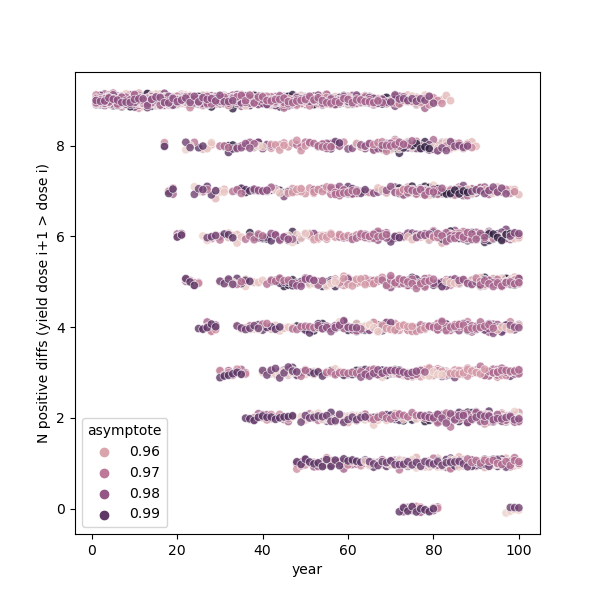

In [147]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='n_pos_diff',
    
    # hue='mu',
    # size='b',
    
    # hue='dec_rate_multiplier',
    hue='asymptote',
    
    data=(
        processed_p
        .loc[lambda x: x.asymptote>0.95]
        
        # .loc[lambda x: x.b<1.2]
        # .loc[lambda x: x.b>0.5]
    ),
    ax=ax,
    alpha=0.8,
)

ax.set_ylabel('N positive diffs (yield dose i+1 > dose i)')

(0.0, 50.0)

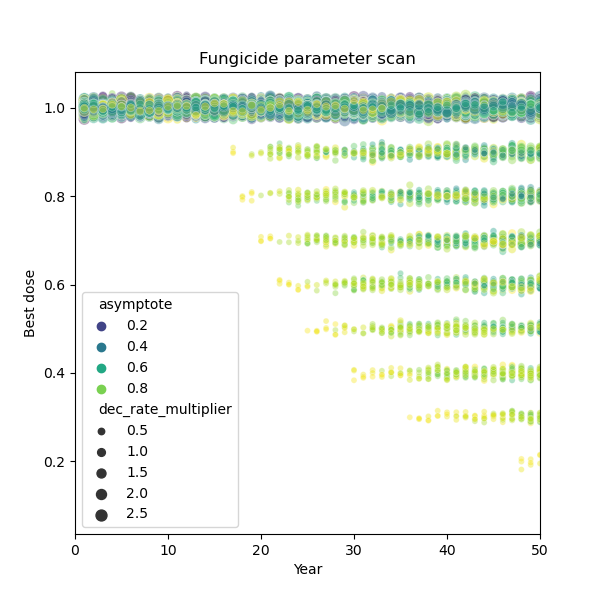

In [148]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='best_dose',
    
    # hue='dec_rate_multiplier',
    hue='asymptote',
    
    size='dec_rate_multiplier',
    
    data=(
        processed_p
        # .loc[lambda x: x.asymptote>0.8]
        # .loc[lambda x: x.mu>5]
        # .loc[lambda x: x.mu>12]
        
        # .loc[lambda x: x.b>0.5]
        # .loc[lambda x: x.b<1.5]
        
        # .loc[lambda x: x.b>1]
        # .loc[lambda x: x.b>0.2]
    ),
    ax=ax,
    palette='viridis',
    alpha=0.4,
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Fungicide parameter scan')

# ax.legend(loc='upper right')

ax.set_xlim([0,50])

In [149]:
f.savefig('../figures/rough/scan/fung_pars.jpg')

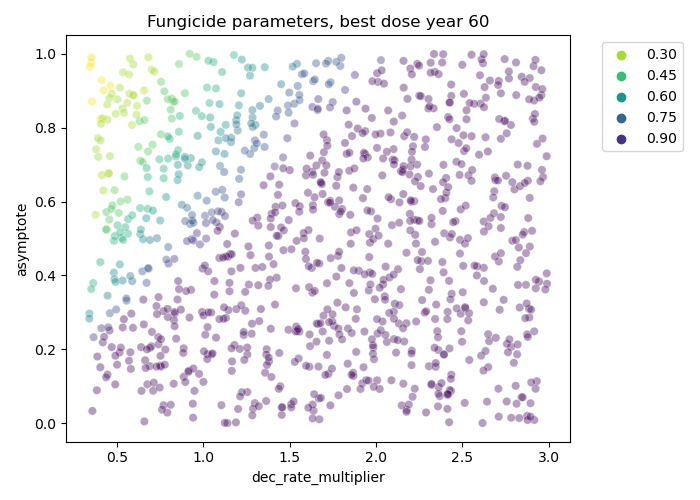

In [172]:
f, ax = plt.subplots(figsize=(7, 5))

dfu = processed_p.loc[lambda x: x.year.isin([60])]

sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    # style='year',
    # size='year',
    data=dfu,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.set_title('Fungicide parameters, best dose year 60')
plt.tight_layout()

In [173]:
f.savefig('../figures/rough/scan/fung_pars_colour.jpg')

So seemingly low doses become better more quickly for low decay rates. More selection if fungicide lingers for longer, so then high doses become relatively poorer? But there is also this trade off with control so not completely obvious.

But still doesn't happen for almost 20 years.

Happens faster for bigger asymptotes - relatively increased selection due to bigger diff between dose response curves.

# Mutation scan

In [155]:
dm = pd.read_csv('../outputs/combined/mut_pars_scan.csv')

In [156]:
dm.head()

run  year  best_dose  n_pos_diff  m_prop_multiplier  m_scale_multiplier
0    0     1        1.0           9           1.252065            2.693883
1    0     2        1.0           9           1.252065            2.693883
2    0     3        1.0           9           1.252065            2.693883
3    0     4        1.0           9           1.252065            2.693883
4    0     5        1.0           9           1.252065            2.693883

In [158]:
noise_m = np.random.normal(0, 0.05, size=len(dm.n_pos_diff))

processed_m = (
    dm
    .assign(
        is_mono = lambda x: (x.n_pos_diff==9).astype(int) + 2*noise,
        n_pos_diff = lambda x: x.n_pos_diff + noise,
        best_dose = lambda x: x.best_dose + 0.15*noise,
    )
)

Text(0, 0.5, 'is monotonic?')

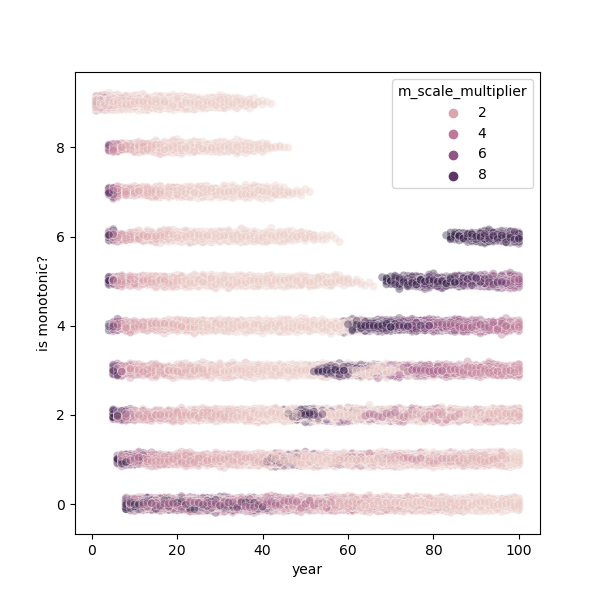

In [159]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='n_pos_diff',
    
    # hue='m_prop_multiplier',
    hue='m_scale_multiplier',
    
    # size='b',
    # size='mu',
    
    data=(
        processed_m
        # .loc[lambda x: x.m_scale_multiplier>1]
        # .loc[lambda x: x.mu>5]
        
        # .loc[lambda x: x.b>3]
        # .loc[lambda x: x.b>0.2]
    ),
    ax=ax,
    alpha=0.4,
)

ax.set_ylabel('is monotonic?')

More rapid change to low better if mutation scale or prop are higher

Text(0, 0.5, 'N positive diffs (yield dose i+1 > dose i)')

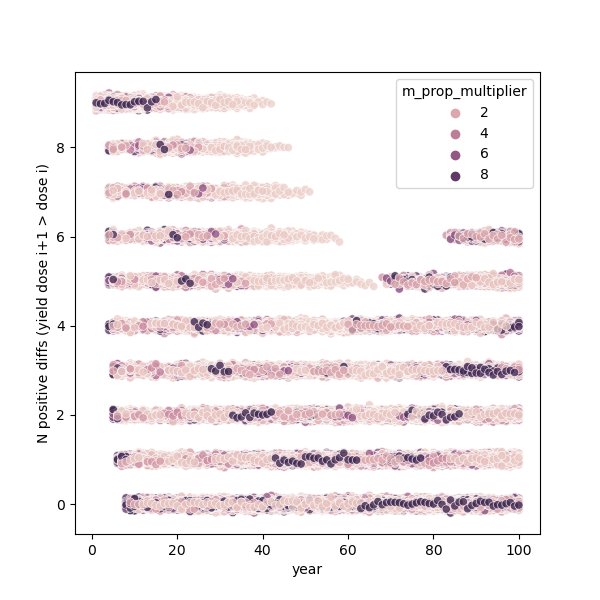

In [160]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='n_pos_diff',
    
    # hue='mu',
    # size='b',
    
    hue='m_prop_multiplier',
    # hue='m_scale_multiplier',
    
    data=(
        processed_m
        # .loc[lambda x: x.asymptote>0.95]
        
        # .loc[lambda x: x.b<1.2]
        # .loc[lambda x: x.b>0.5]
    ),
    ax=ax,
    alpha=0.8,
)

ax.set_ylabel('N positive diffs (yield dose i+1 > dose i)')

(0.0, 50.0)

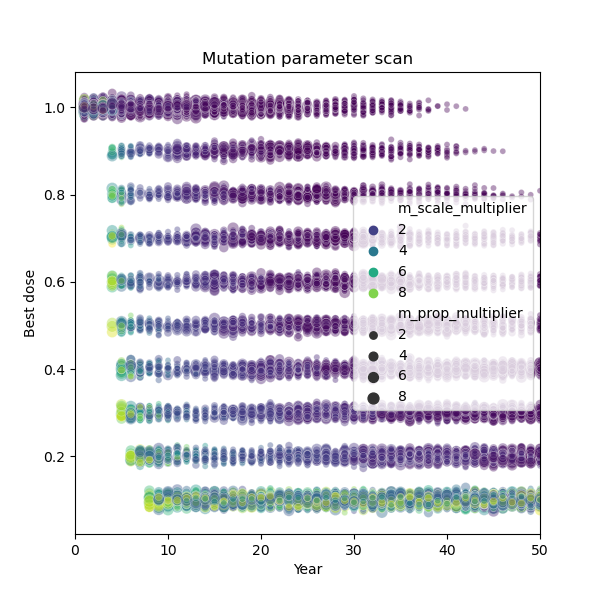

In [161]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='best_dose',
    
    size='m_prop_multiplier',
    
    # hue='m_prop_multiplier',
    hue='m_scale_multiplier',
    
    data=(
        processed_m
        # .loc[lambda x: x.m_prop_multiplier>1]
        # .loc[lambda x: x.m_scale_multiplier>1]
        # .loc[lambda x: x.m_scale_multiplier<3]
        
        # .loc[lambda x: x.b<1.2]
        # .loc[lambda x: x.b>0.5]
    ),
    ax=ax,
    alpha=0.4,
    palette='viridis',
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Mutation parameter scan')

ax.legend(loc='right')

ax.set_xlim([0,50])

In [162]:
f.savefig('../figures/rough/scan/mut_pars.jpg')

<ipython-input-168-3cc57d1ff85e>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(7, 5))


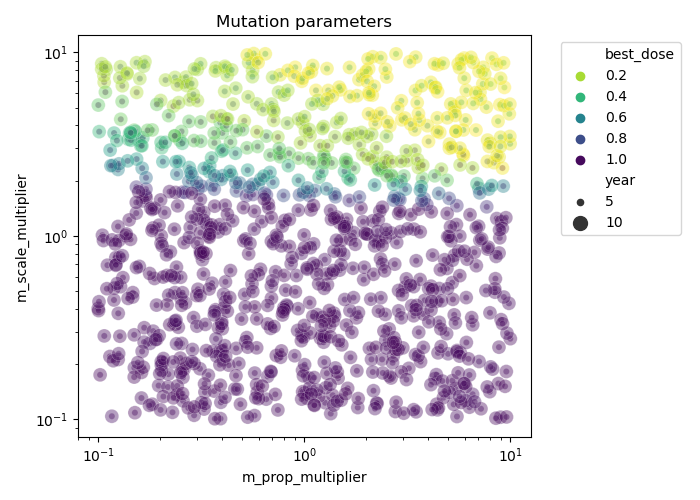

In [168]:
f, ax = plt.subplots(figsize=(7, 5))

dfu = processed_m.loc[lambda x: x.year.isin([5, 10])]

sns.scatterplot(
    x='m_prop_multiplier',
    y='m_scale_multiplier',
    hue='best_dose',
    # style='year',
    size='year',
    data=dfu,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 100)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Mutation parameters')

plt.tight_layout()

In [169]:
f.savefig('../figures/rough/scan/mut_scan_colour.jpg')

Possible rebound effect? Would need to investigate more closely distributions etc, but suspect basically lots of density near 1 and then high becomes better again

# Scan over all

In [176]:
dfa = pd.read_csv('../outputs/combined/scan_all.csv')

dfa.head()

run  year  best_dose  n_pos_diff         mu         b  asymptote  \
0    0     1        1.0           9  17.879734  2.744068   0.602763   
1    0     2        1.0           9  17.879734  2.744068   0.602763   
2    0     3        1.0           9  17.879734  2.744068   0.602763   
3    0     4        1.0           9  17.879734  2.744068   0.602763   
4    0     5        1.0           9  17.879734  2.744068   0.602763   

   dec_rate_multiplier  m_prop_multiplier  m_scale_multiplier  
0             1.786355           0.703574             1.95789  
1             1.786355           0.703574             1.95789  
2             1.786355           0.703574             1.95789  
3             1.786355           0.703574             1.95789  
4             1.786355           0.703574             1.95789

In [177]:
noise_a = np.random.normal(0, 0.05, size=len(dfa.n_pos_diff))

processed_a = (
    dfa
    .assign(
        is_mono = lambda x: (x.n_pos_diff==9).astype(int) + 2*noise,
        n_pos_diff = lambda x: x.n_pos_diff + noise,
        best_dose = lambda x: x.best_dose + 0.15*noise,
    )
)

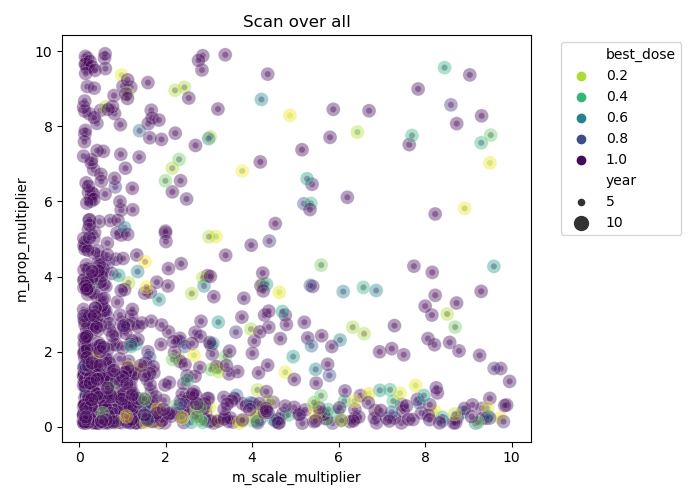

In [194]:
f, ax = plt.subplots(figsize=(7, 5))

dfa2 = processed_a.loc[lambda x: x.year.isin([5, 10])]

v1 = 'm_scale_multiplier'
v2 = 'm_prop_multiplier'

sns.scatterplot(
    x=v1,
    y=v2,
    hue='best_dose',
    # style='year',
    size='year',
    data=dfa2,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 100)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_title('Scan over all')

plt.tight_layout()

In [195]:
f.savefig(f'../figures/rough/scan/scan_over_all_{v1}_{v2}.jpg')

# Beta scan

In [196]:
dfb = pd.read_csv('../outputs/combined/beta_scan.csv')

dfb.head()

run  year  best_dose  n_pos_diff        mu          b
0    0     1        1.0           9  0.000092  28.607575
1    0     2        1.0           9  0.000092  28.607575
2    0     3        1.0           9  0.000092  28.607575
3    0     4        1.0           9  0.000092  28.607575
4    0     5        1.0           9  0.000092  28.607575

In [197]:
noise_b = np.random.normal(0, 0.05, size=len(dfb.n_pos_diff))

processed_b = (
    dfb
    .assign(
        is_mono = lambda x: (x.n_pos_diff==9).astype(int) + 2*noise,
        n_pos_diff = lambda x: x.n_pos_diff + noise,
        best_dose = lambda x: x.best_dose + 0.15*noise,
    )
)

(0.0, 50.0)

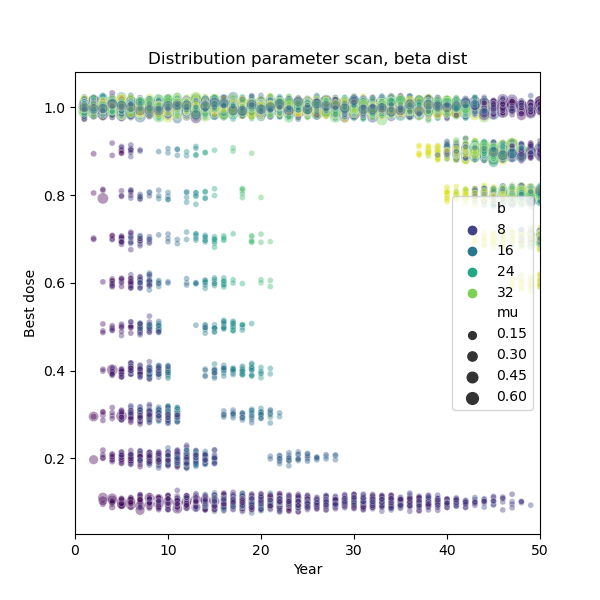

In [209]:
f, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(
    x='year',
    y='best_dose',
    
    size='mu',
    
    hue='b',
    
    data=(
        processed_b
        # .loc[lambda x: x.m_prop_multiplier>1]
        # .loc[lambda x: x.m_scale_multiplier>1]
        # .loc[lambda x: x.m_scale_multiplier<3]
        
        # .loc[lambda x: x.b<1.2]
        # .loc[lambda x: x.b>0.5]
    ),
    ax=ax,
    alpha=0.4,
    palette='viridis',
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Distribution parameter scan, beta dist')

ax.legend(loc='right')

ax.set_xlim([0,50])

In [210]:
f.savefig(f'../figures/rough/scan/beta_dist_years.jpg')

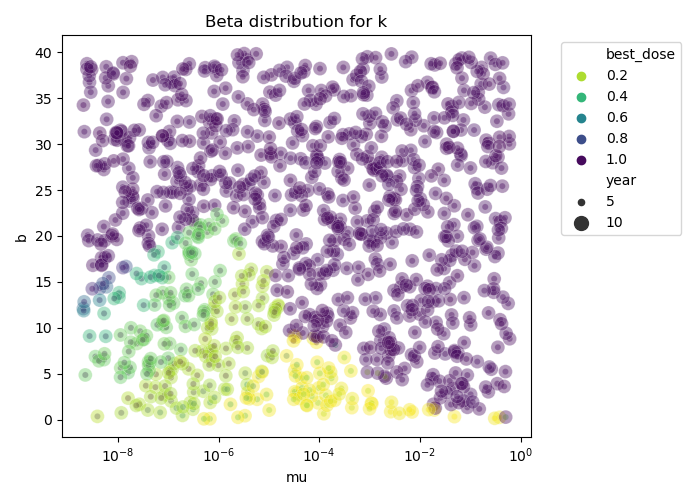

In [203]:
f, ax = plt.subplots(figsize=(7, 5))

dfb2 = processed_b.loc[lambda x: x.year.isin([5, 10])]

sns.scatterplot(
    x='mu',
    y='b',
    
    hue='best_dose',
    # style='year',
    size='year',
    data=dfb2,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 100)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_title('Beta distribution for k')

plt.tight_layout()

In [204]:
f.savefig('../figures/rough/scan/beta_dist_colours.jpg')

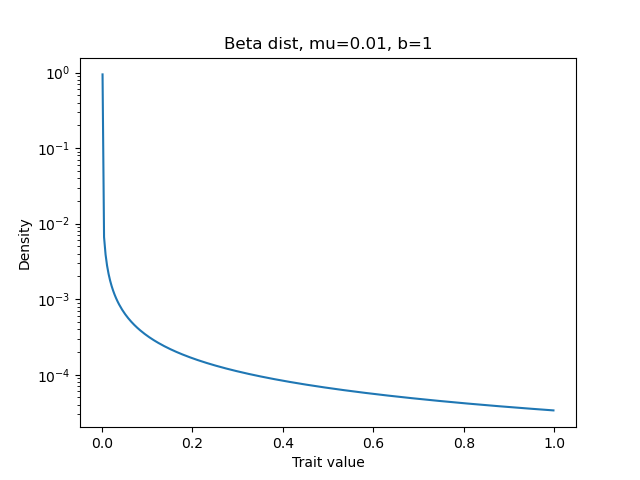

In [207]:
mu = 1e-2
b = 1

a = b*mu/(1-mu)

xx = trait_vec(300)

yy = beta_dist(300, a, b)

f, ax = plt.subplots()

ax.plot(xx, yy)

ax.set_xlabel('Trait value')
ax.set_ylabel('Density')

# ax.set_yscale('Density')

ax.set_title(f'Beta dist, {mu=}, {b=}')

ax.set_yscale('log')

In [208]:
f.savefig('../figures/rough/scan/beta_dist.jpg')

# Conclusions

If want low dose to become better faster, choose:

- low decay rate
- high asymptote (or =1)
- high mutation prop
- high mutation scale
- `b<1`
- higher values `mu` (i think?)


# To do next

Check a beta distribution instead of gamma

Check what happens when polygenic trait affects asymptote not curvature - suspect then low doses much better

# Rough

In [233]:
from poly2.simulator import SimulatorAsymptote

In [239]:
from poly2.config import get_asymptote_config

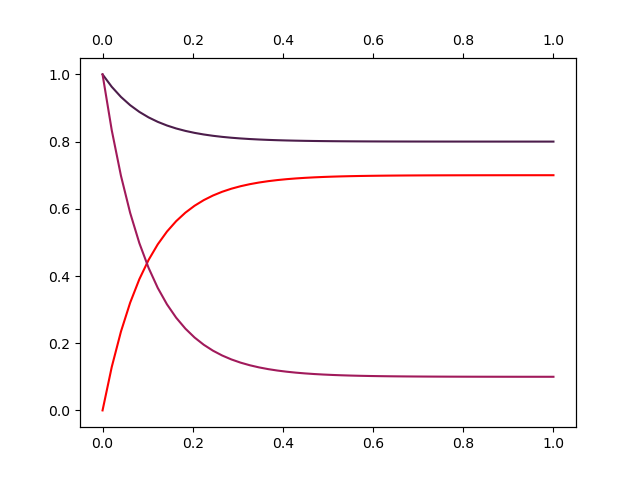

In [377]:
f, ax = plt.subplots()

xx = np.linspace(0,1)

w1 = 0.2
w2 = 0.9

cv = 10

y1 = 1 - w1 * (1 - np.exp( - xx * cv))
y2 = 1 - w2 * (1 - np.exp( - xx * cv))

ax.plot(xx, y1 - y2, c='r')

ax2 = ax.twiny()

ax2.plot(xx, y1)
ax2.plot(xx, y2)

In [433]:
cf = get_asymptote_config(
    verbose=False,
    n_k=100,
    n_years=30,              
    k_mu=0.95,
    k_b=1.8,
    curvature=10
)

cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
curvature = 10
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
k_b = 1.8
k_mu = 0.95
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
n_k = 100
n_years = 30
sprays = None



In [434]:
s = SimulatorAsymptote(cf)

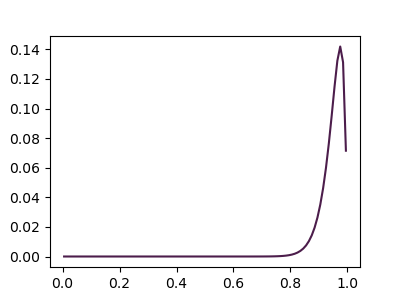

In [435]:
f, ax = plt.subplots(figsize=(4,3))

ax.plot(s.k_vec, s.initial_k_dist)

In [436]:
data_list = []

doses = np.linspace(0,1,5)[1:]

for dose in doses:
    cf.doses = np.ones(cf.n_years)*dose
    data = s.run_model()
    data_list.append(data)

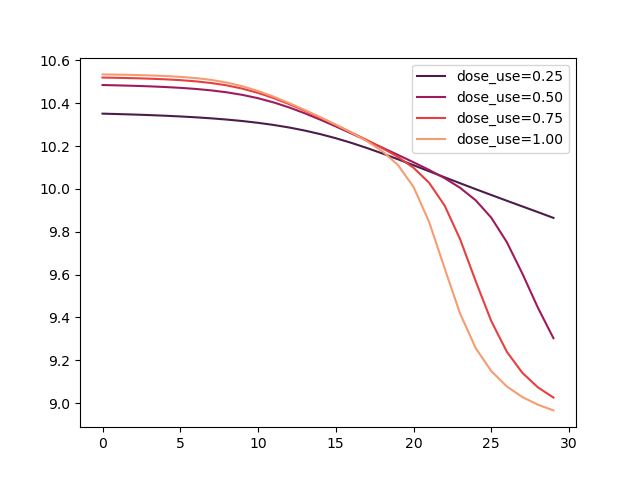

In [437]:
f, ax = plt.subplots()

sns.set_palette('rocket', n_colors=4)

for ind, dd in enumerate(data_list):
    dose_use = doses[ind]
    
    ax.plot(dd['yield_vec'], label=f'{dose_use=:.2f}')
    
ax.legend()

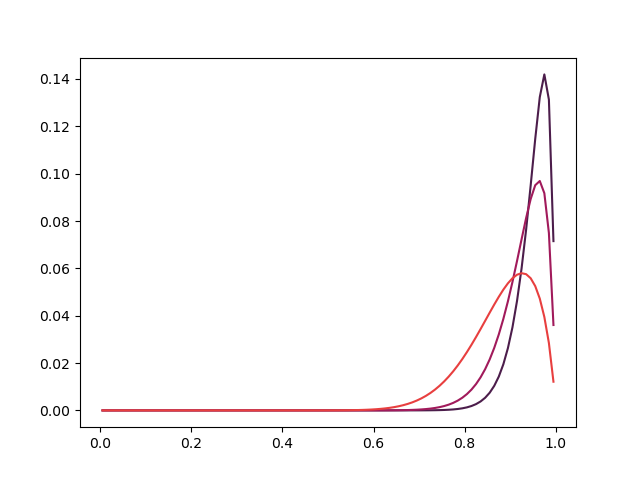

In [438]:
f, ax = plt.subplots()

for ii in range(0, 15, 5):
    ax.plot(data_list[0]['k_vec'], data_list[0]['fung_dists'][:, ii])

Conclusions:

- high curvature good for low dose best
- high b good for low dose best
- think want high mu

Need to be careful that curvature not so high that it stays too flat initially, or that dose response looks silly 

Something like this looks decent:

```
cf = get_asymptote_config(
    verbose=False,
    n_k=100,
    n_years=30,              
    k_mu=0.96,
    k_b=2,
    curvature=20
)
```



Next steps:

- try fitting to Frank data (quickly)
- see what that model does, if crap then try custom parameters to demonstrate effect
- hope for something which fairly consistently gives high doses best
- probably show that range of outcomes possible again